In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import sklearn
# fix random seed for reproducibility
np.random.seed(7)

from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import acf
from tbats import BATS, TBATS
ROOT = "C:/Users/"

# MODELO CON TBATS

Este cuaderno va a tratar de aprovechar los algoritmos TBATS, especializados en estacionalidad, para poder realizar una predicción. La naturaleza de esta predicción depende en gran medida de valores anteriores y esto será un handicap igual que con SARIMAX.

Los siguientes enlaces contienen unas guías que explican bien todo el algoritmo:

- https://medium.com/analytics-vidhya/time-series-forecasting-using-tbats-model-ce8c429442a9
- https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a

In [2]:
# Función para el split de los datos.
def divide(df, proporcion = 0.75):
    corte = round(len(df)*proporcion)
    train = df[:corte]
    test = df[corte:]
    return train, test

# Métricas de performance.
def forecast_accuracy(forecast, actual):
    #=============================================================== AÑADIDO PARA DIFERENTES ARRAY
    if (len(forecast) != len(actual)):
        if (len(forecast) < len(actual)):
            actual = actual[:len(forecast)]
        else:
            forecast = forecast[:len(actual)]
    #===============================================================
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual) / actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]   # corr
    mins = np.amin(np.hstack([forecast[:, None], actual[:,None]]), axis = 1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:,None]]), axis = 1)
    minmax = 1 - np.mean(mins / maxs)             # minmax
    acf1 = acf(forecast - actual)[1]                      # autocorrelacion del error, primer lag
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 'corr':corr, 'minmax':minmax})

Código extraído del cuaderno del estudio de datos.

In [26]:
# los tres dataset
df_clientes = pd.read_csv(ROOT + ".csv", delimiter = ',')
df_dim_pedidos = pd.read_csv(ROOT + ".csv", delimiter = ',')
df_pedidos = pd.read_csv(ROOT + ".csv", delimiter = ',')
df_clientes = df_clientes.dropna()
df_dim_pedidos = df_dim_pedidos.dropna()
df_pedidos = df_pedidos.dropna()

# selecciona el id y la cantidad de pedidos en tabla auxiliar
df_aux = pd.DataFrame()
df_aux['cantidad'] = df_pedidos.groupby('digit_digit_sm_idpedido')['digit_digit_sm_cantidad'].sum()
df_aux = df_aux.reset_index() # groupby convierte la variable clave en index, por lo que hay que desconvertir

# crea un dataframe para unirlo todo
df = pd.DataFrame()
df['timestamp'] = pd.to_datetime(df_dim_pedidos['digit_digit_sm_fechapedido']) # extrae fechas
df = df[df['timestamp'] > '2015-01-01'] # a partir del año del comportamiento actual
#df = df[df['timestamp'] < '2021-06-01'] # omitiendo los picos de ventas post-covid
df['id_pedido'] = df_dim_pedidos['digit_digit_sm_idpedido'] # extrae id para añadir la informacion del pedido
df = df.join(df_aux.set_index('digit_digit_sm_idpedido'), on = 'id_pedido') # añade informacion de pedido
df = df.drop(['id_pedido'], axis = 1) # elimina la columna auxiliar de los pedidos
df = df.sort_values(by = 'timestamp', ascending = True) # ordena segun el timestamp
# TBATS no tolera variables exógenas
#df['crisis_oferta'] = 0 # Se va a crear una columna de crisis de oferta para intentar reflejar el efecto del covid
#df['crisis_oferta'].loc[(df['timestamp'] > '2020-03-14') & (df['timestamp'] < '2021-05-01')] = 1
df['week'] = df['timestamp'].dt.isocalendar().week # una columna con la semana del año
df['year'] = df['timestamp'].dt.year # una columna por año
df = df.set_index(['week', 'year']) # establece semanas y años de index para agrupar segun ellos
df['cantidad'] = df.groupby(['week', 'year'])['cantidad'].sum() # agrupa los pedidos que se produjeron la misma semana del año
df = df[~ df.index.duplicated(keep = 'first')] # elimina las replicas que se han producido en la agrupacion anterior
df = df.reset_index().set_index(['timestamp']) # cambia timestamp de index
df = df.drop(['week', 'year'], axis = 1) # elimina las columnas innecesarias
df['cantidad'] = df['cantidad'].rolling(1, center = True, closed = 'both').mean() # suavizado mediante Moving Average
# elimina nan
print(df.shape)
df = df.dropna()
print(df.shape)
df = df[df['cantidad'] > 0] # elimina negativos y ceros para poder aplicar seasonal
df['cantidad'] = df['cantidad'].rolling(1, center = True, closed = 'both').mean() # suavizado mediante Moving Average
df

(362, 1)
(362, 1)


,cantidad
timestamp,
2015-01-02,4665.00
2015-01-06,7207.00
2015-01-12,11633.50
2015-01-19,12848.25
2015-01-26,11710.00
...,...
2021-11-01,16430.00
2021-11-10,8274.50
2021-12-01,11358.25


# =============================================================

### Predicción del modelo incluyendo la caida del covid

Una de las características esenciales del modelado TBATS es que necesita que se cree una historia consistente con los datos, como todos los demás. Cuando se realiza un split, no se deben desordenar los datos. Además, si se desea predecir datos posteriores al presente (predecir el futuro) se necesita comprender el presente y el pasado cercano. Es por eso que no se pueden omitir los datos de los valles y picos del COVID.

In [27]:
# TBATS necesita un index sin timestamp
df_no_index = df.reset_index(drop = True)
train, test = divide(df_no_index, 0.9) # La función propia split propia.
print(len(train))
print(len(test))

326
36


El modelo TBATS necesita que se le añada un periodo equivalente al número de muestras por ciclo para programar el **estimador**. Si se desease realizar una predicción diaria sería seasonal_periods = (7, 365.25), 7 por los días de la semana y 365,25 por los días del año.

En este caso se trata se semanas por año ya que la frecuencia es semanal, y un año dispone de 52,1429 semanas. Modificarligeramente esta frecuencia implicaría que la predicción se distorsiona, y este hiperparámetro es extremadamente sensible.

En el caso de la siguiente predicción, el hiperparámetro se puede distorsionar ligeramente (52,18 semanas) para realizar una predicción más suave y genérica. El código puede ser optimizado empleando el período exacto, pero los valores han sido optimizados por ensayo y error.

In [5]:
training_start = time.perf_counter() # inicia entrenamiento

estimator = TBATS(seasonal_periods = (1, 52.1429)) # El periodo exacto original.
#estimator = TBATS(seasonal_periods = (1, 52.18)) # Una prediccion mas suave con un periodo mas grande.
model = estimator.fit(train['cantidad'])

training_end = time.perf_counter() # finaliza entrenamiento
train_time = training_end - training_start
print("Time consumed in training: %.3f" % train_time, "seconds")

D:\Python\lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: All seasonal periods should be values greater than 1. Ignoring all seasonal period values that do not meet this condition.
  warnings.warn(message, warning_type)


Predicción:

In [6]:
forecast = model.forecast(steps = len(test)) # se va a tomar la misma cantidad de steps en el futuro que de test.

Los estadísticos muestran que que la predicción no es muy buena, con una correlación del 22% y un accuracy del 52%.

In [7]:
forecast_accuracy(forecast, test['cantidad'])

<ipython-input-2-59b49a6db948>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:, None], actual[:,None]]), axis = 1)
<ipython-input-2-59b49a6db948>:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:, None], actual[:,None]]), axis = 1)
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release

{'mape': 0.38950346076926257,
 'me': -2572.1976352251777,
 'mae': 6884.207445788214,
 'mpe': 0.05883434828628203,
 'rmse': 9425.034924280364,
 'acf1': 0.5223150925773943,
 'corr': 0.21337596155664146,
 'minmax': 0.2918927333448603}

Representación de la predicción para compararla con el test. En este caso se aprecia que la predicción se aproxima (aunque poco) a la predicción hasta llegar al pico de ventas disparado tras la apertura postcovid, lo cual señala que esta predicción es susceptible de verse alterada por estas irregularidades y no es buena para baja regularidad.

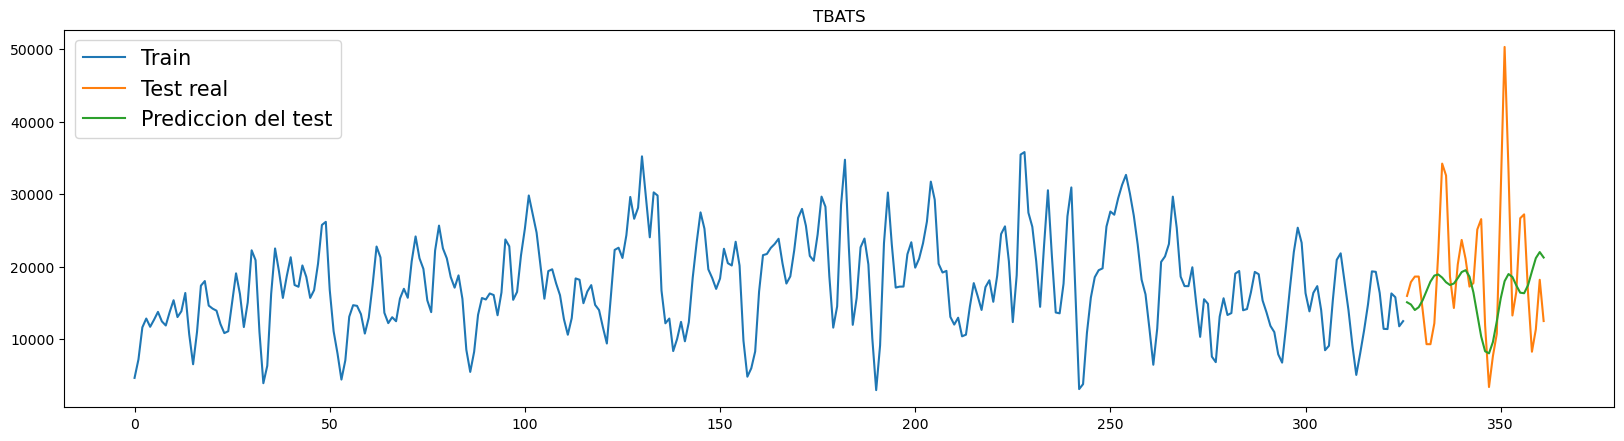

In [8]:
# Preparación del plot de los valores reales.
plot_test = np.full([len(df_no_index)], np.nan) # Se crea un vector sin datos del tamaño del dataset completo para el plot.
plot_test[len(train):len(df_no_index)] = test['cantidad'] # Se colocan los datos del test después del train.
# Preparación del plot de la predicción.
plot_forecast_post_covid = np.full([len(df_no_index)], np.nan)
plot_forecast_post_covid[len(train):len(df_no_index)] = forecast # Se colocan los datos de la predicción después del train.

# Representación.
plt.figure(figsize = (20, 5), dpi = 100)
plt.plot(train, label = 'Train')
plt.plot(plot_test, label = 'Test real')
plt.plot(plot_forecast_post_covid, label = 'Prediccion del test')
plt.title('TBATS')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

Para el estudio de errores residuales en la predicción del mismo modelo se puede aprovechar un histograma y un diagrama de densidad que revelasen como la distribución en los errores tiene una forma en torno al 0, lo más parecida a una campana de Gauss posible. El problema es que estos errores están reflejados tanto en el histograma como en el diagrama de densidad, completamente desajustados alrededor de 0 de manera que hay una gran desviación e irregularidad.

Por el lado del diagrama Q-Q, se trata de un scatter plot cuyos valores tienden (o deberían tender) a acumularse en torno a una diagonal que en este caso es completamente inexistente a simple vista. Esto podría revelar un gran bias respecto del valor esperable, concordando con los diagramas ya comentados.

Estos diagramas han sido proporcionados por el siguiente artículo;

- https://machinelearningmastery.com/visualize-time-series-residual-forecast-errors-with-python/

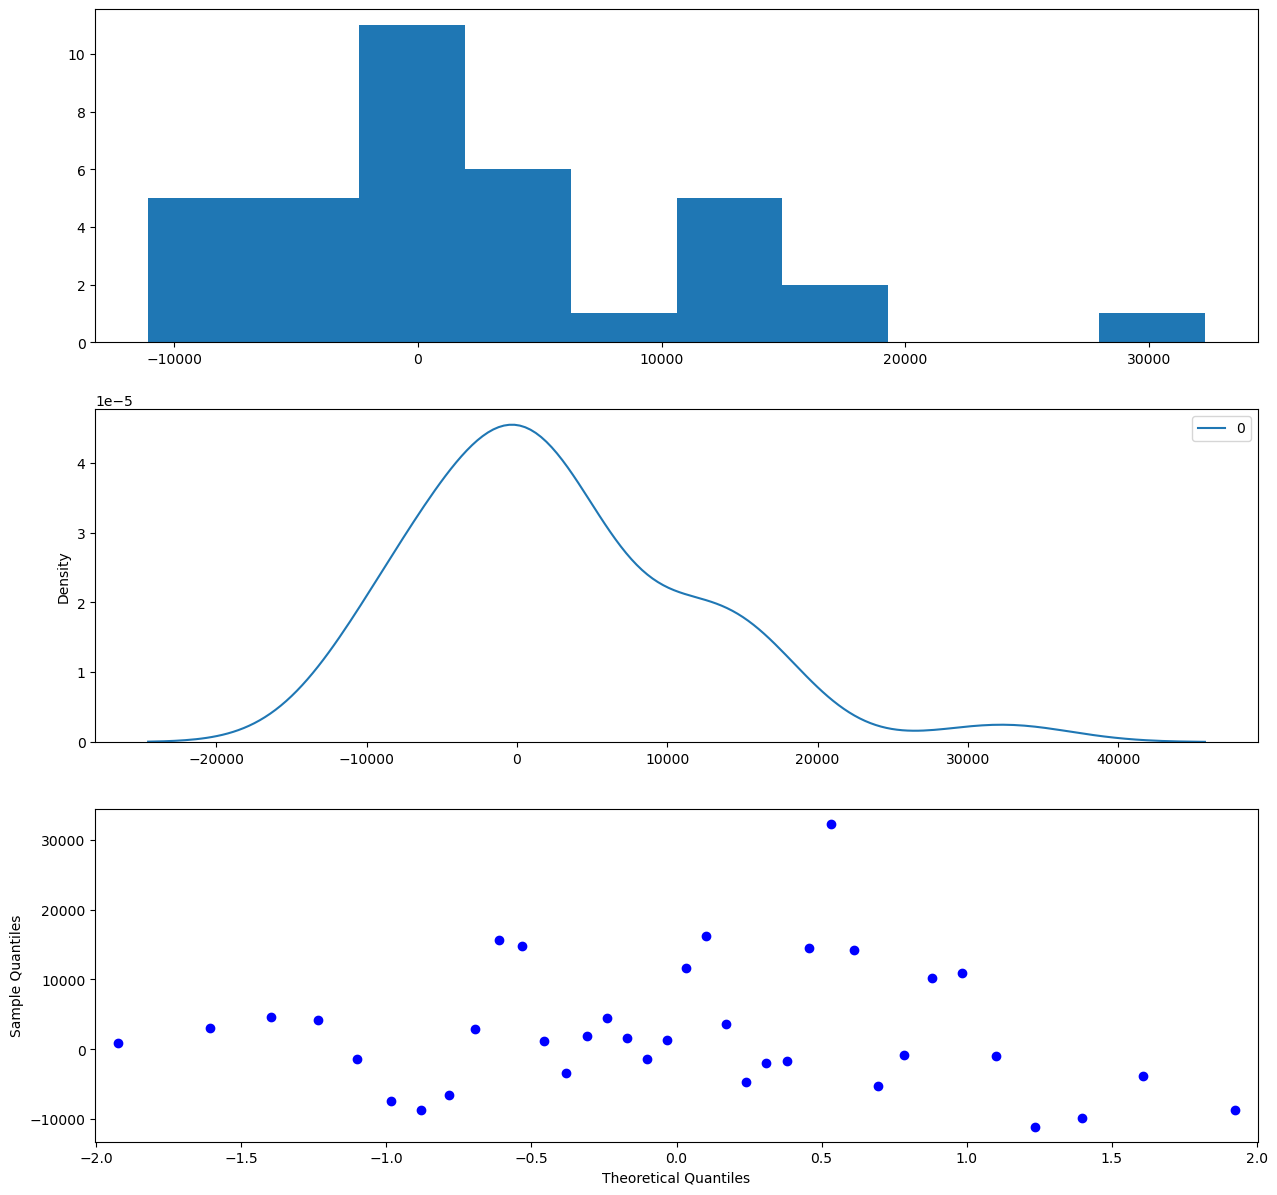

In [9]:
fig, ax = plt.subplots(3, figsize = (15, 15), dpi = 100)
residuos = pd.DataFrame([test['cantidad'].values[i] - forecast[i] for i in range(len(forecast))])
ax[0].hist(residuos) # histograma
sns.kdeplot(data = residuos, ax = ax[1]) # diagrama de densidad
sm.qqplot(residuos, ax = ax[2]) # diagrama del error residual Q-Q en forma de bias
plt.show()

# =============================================================

### Predicción del modelo si el covid no hubiera ocurrido

Aunque realizar predicciones para despues de la pandemia resulta imposible si tener en cuenta los mismos datos de la pandemia, es interesante Observar que hubiese ocurrido con la predicción de no haberse visto alterada por la anomalía de la pandemia.

In [10]:
df_precovid = df[df.index < '2020-01-01'] # Omitiendo el periodo covid.
# TBATS necesita un index sin timestamp
df_no_index_precovid = df_precovid.reset_index(drop = True)
train, test = divide(df_no_index_precovid, 0.9)
print(len(train))
print(len(test))

235
26


En este caso, la frecuencia ajustada no encajaba con la propia frecuencia necesitada para el modelo, y tuvo que buscarse una frecuencia más baja por iteración.

In [11]:
training_start = time.perf_counter() # inicia entrenamiento

#estimator = TBATS(seasonal_periods = (1, 52.1429)) # El periodo exacto original.
estimator = TBATS(seasonal_periods = (1, 52.085)) # Una prediccion mas suave con un periodo mas grande.
model = estimator.fit(train['cantidad'])

training_end = time.perf_counter() # finaliza entrenamiento
train_time = training_end - training_start
print("Time consumed in training: %.3f" % train_time, "seconds")

forecast = model.forecast(steps = len(test))

D:\Python\lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: All seasonal periods should be values greater than 1. Ignoring all seasonal period values that do not meet this condition.
  warnings.warn(message, warning_type)


Este casi tiene una predicción que si bien numericamente no se aproxima de manera fiable a la realidad, si que tiene una forma que define el comportamiento del sistema.

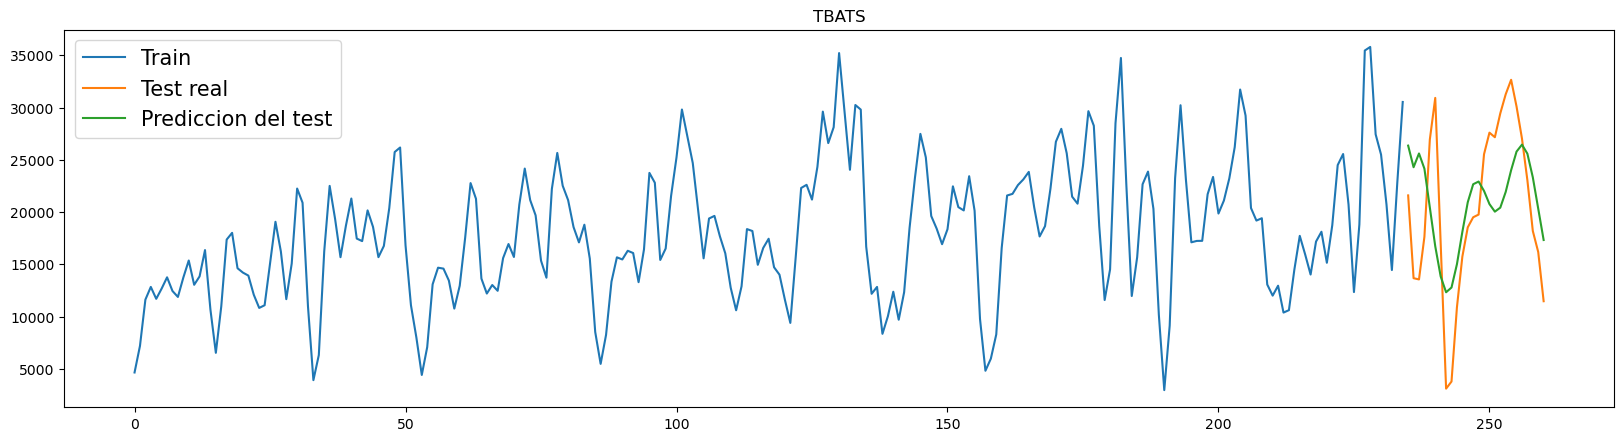

In [12]:
# Preparación del plot de los valores reales.
plot_test = np.full([len(df_no_index_precovid)], np.nan)
plot_test[len(train):len(df_no_index_precovid)] = test['cantidad']
# Preparación del plot de la predicción.
plot_forecast_pre_covid = np.full([len(df_no_index_precovid)], np.nan)
plot_forecast_pre_covid[len(train):len(df_no_index_precovid)] = forecast

plt.figure(figsize = (20, 5), dpi = 100)
plt.plot(train, label = 'Train')
plt.plot(plot_test, label = 'Test real')
plt.plot(plot_forecast_pre_covid, label = 'Prediccion del test')
plt.title('TBATS')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

Salvo por el tercer diagrama Q-Q de los residuos que es disperso y poco ilustrativo en este caso, los diagramas muestran como de hecho los errores han empeorado de manera que hay una mayor dispersión y se han alejado del cero mucho más. 

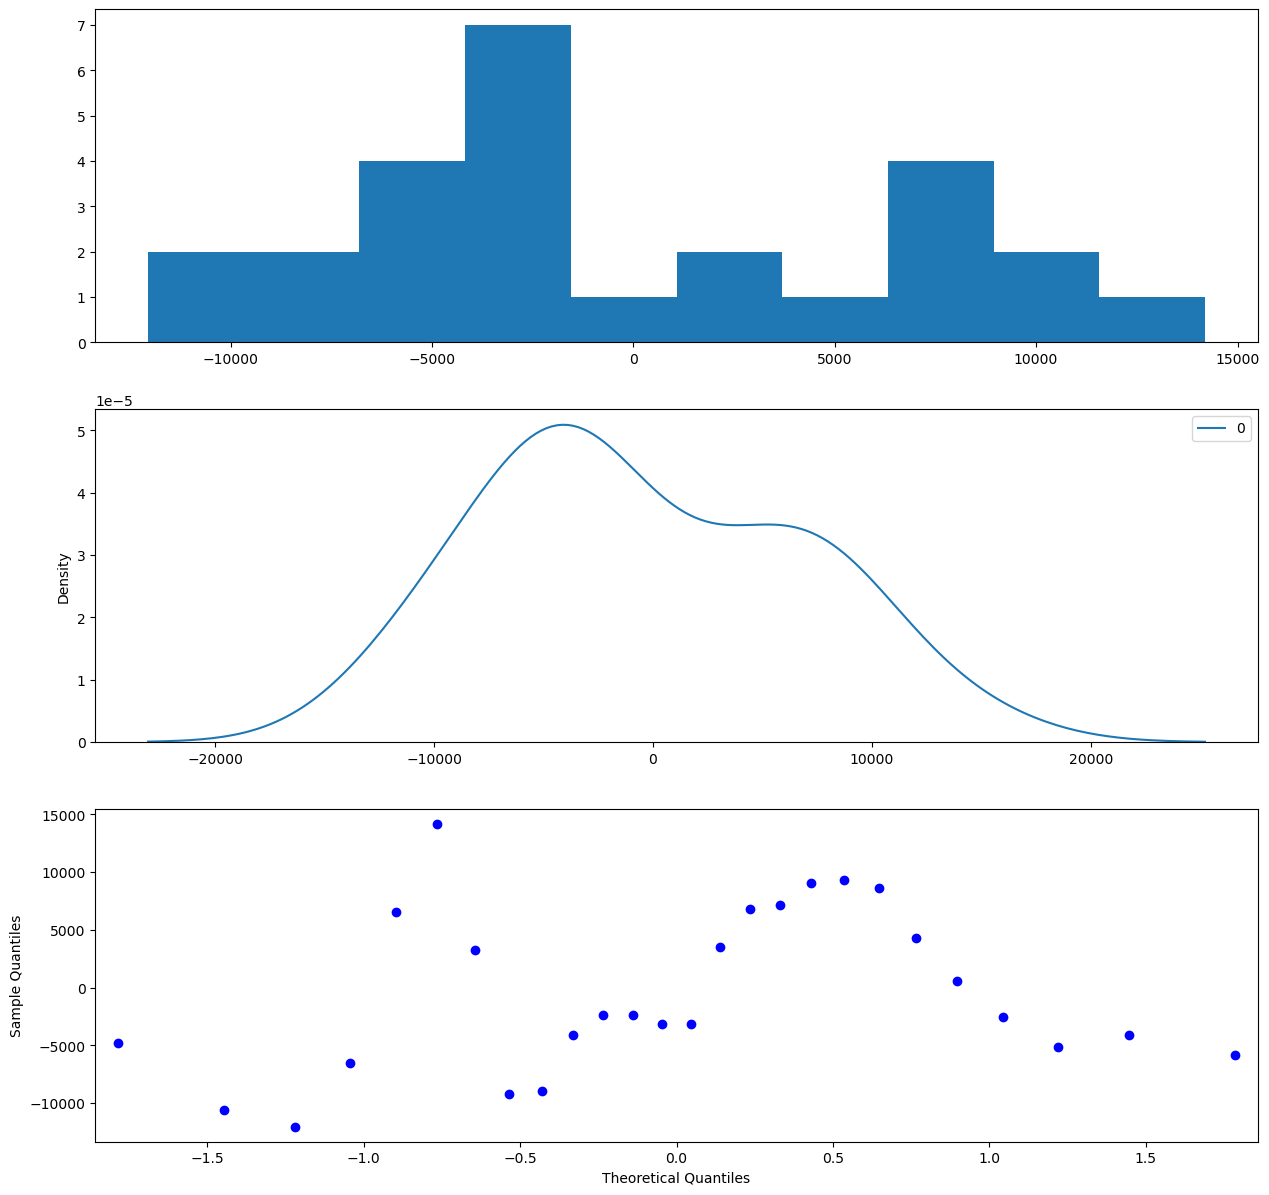

In [13]:
fig, ax = plt.subplots(3, figsize = (15, 15), dpi = 100)
residuos = pd.DataFrame([test['cantidad'].values[i] - forecast[i] for i in range(len(forecast))])
ax[0].hist(residuos)
sns.kdeplot(data = residuos, ax = ax[1])
sm.qqplot(residuos, ax = ax[2])
plt.show()

Ha desarrollado una correlación del 25% frente a la del 22% cuando se tenía en cuenta el período covid, anque como se ha visto anteriormente, la forma si que ha sido aproximada de manera más precisa.

In [14]:
forecast_accuracy(forecast, test['cantidad'])

<ipython-input-2-59b49a6db948>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:, None], actual[:,None]]), axis = 1)
<ipython-input-2-59b49a6db948>:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:, None], actual[:,None]]), axis = 1)
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release

{'mape': 0.4724351923578237,
 'me': 448.9105159362838,
 'mae': 6089.755474870781,
 'mpe': 0.2745280750853899,
 'rmse': 6926.870753210351,
 'acf1': 0.6944544859040742,
 'corr': 0.5095090767261616,
 'minmax': 0.2706552390079142}

# =============================================================

### Modelo TBATS para una predicción mensual

Dado que el modelo no es de por si muy regular en su estacionalidad, es interesante estudiar si hubiera sido más factible estudiando la mensualidad.

In [31]:
# los tres dataset
df_clientes = pd.read_csv(ROOT + "dClientes.csv", delimiter = ',')
df_dim_pedidos = pd.read_csv(ROOT + "dPedidos.csv", delimiter = ',')
df_pedidos = pd.read_csv(ROOT + "fPedidos.csv", delimiter = ',')
df_clientes = df_clientes.dropna()
df_dim_pedidos = df_dim_pedidos.dropna()
df_pedidos = df_pedidos.dropna()

# selecciona el id y la cantidad de pedidos en tabla auxiliar
df_aux = pd.DataFrame()
df_aux['cantidad'] = df_pedidos.groupby('digit_digit_sm_idpedido')['digit_digit_sm_cantidad'].sum()
df_aux = df_aux.reset_index() # groupby convierte la variable clave en index, por lo que hay que desconvertir

# crea un dataframe para unirlo todo
df = pd.DataFrame()
df['timestamp'] = pd.to_datetime(df_dim_pedidos['digit_digit_sm_fechapedido']) # extrae fechas
df = df[df['timestamp'] > '2015-01-01'] # a partir del año del comportamiento actual
#df = df[df['timestamp'] < '2021-06-01'] # omitiendo los picos de ventas post-covid
df['id_pedido'] = df_dim_pedidos['digit_digit_sm_idpedido'] # extrae id para añadir la informacion del pedido
df = df.join(df_aux.set_index('digit_digit_sm_idpedido'), on = 'id_pedido') # añade informacion de pedido
df = df.drop(['id_pedido'], axis = 1) # elimina la columna auxiliar de los pedidos
df = df.sort_values(by = 'timestamp', ascending = True) # ordena segun el timestamp
# TBATS no tolera variables exógenas
#df['crisis_oferta'] = 0 # Se va a crear una columna de crisis de oferta para intentar reflejar el efecto del covid
#df['crisis_oferta'].loc[(df['timestamp'] > '2020-03-14') & (df['timestamp'] < '2021-05-01')] = 1
df['year'] = df['timestamp'].dt.year # una columna para el año
#====================================================================================
df['month'] = df['timestamp'].dt.month # una columna para el mes
#====================================================================================
df = df.set_index(['month', 'year']) # establece semanas y años de index para agrupar segun ellos
df['cantidad'] = df.groupby(['month', 'year'])['cantidad'].sum() # agrupa los pedidos que se produjeron la misma semana del año
df = df[~ df.index.duplicated(keep = 'first')] # elimina las replicas que se han producido en la agrupacion anterior
df = df.reset_index().set_index(['timestamp']) # cambia timestamp de index
df = df.drop(['month', 'year'], axis = 1) # elimina las columnas innecesarias
df['cantidad'] = df['cantidad'].rolling(1, center = True, closed = 'both').mean() # suavizado mediante Moving Average
# elimina nan
print(df.shape)
df = df.dropna()
print(df.shape)
df = df[df['cantidad'] > 0] # elimina negativos y ceros para poder aplicar seasonal
df['cantidad'] = df['cantidad'].rolling(1, center = True, closed = 'both').mean() # suavizado mediante Moving Average
df

(85, 1)
(85, 1)


,cantidad
timestamp,
2015-01-02,54184.00
2015-02-02,53465.75
2015-03-02,56065.50
2015-04-02,60572.50
2015-05-01,58935.50
...,...
2021-09-02,85545.25
2021-10-02,105834.25
2021-11-01,81092.50


Se propone hacer predicción con y sin la parte del covid.

- Con la parte del covid;

In [32]:
#df = df[df.index < '2020-01-01'] # Omitiendo el periodo covid
# TBATS necesita un index sin timestamp
df_no_index_mensual = df.reset_index(drop = True)
train, test = divide(df_no_index_mensual, 0.9)
print(len(train))
print(len(test))

training_start = time.perf_counter() # inicia entrenamiento

estimator = TBATS(seasonal_periods = (1, 12)) # El periodo exacto original
model = estimator.fit(train['cantidad'])

training_end = time.perf_counter() # finaliza entrenamiento
train_time = training_end - training_start
print("Time consumed in training: %.3f" % train_time, "seconds")

forecast = model.forecast(steps = len(test))

76
9


D:\Python\lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: All seasonal periods should be values greater than 1. Ignoring all seasonal period values that do not meet this condition.
  warnings.warn(message, warning_type)


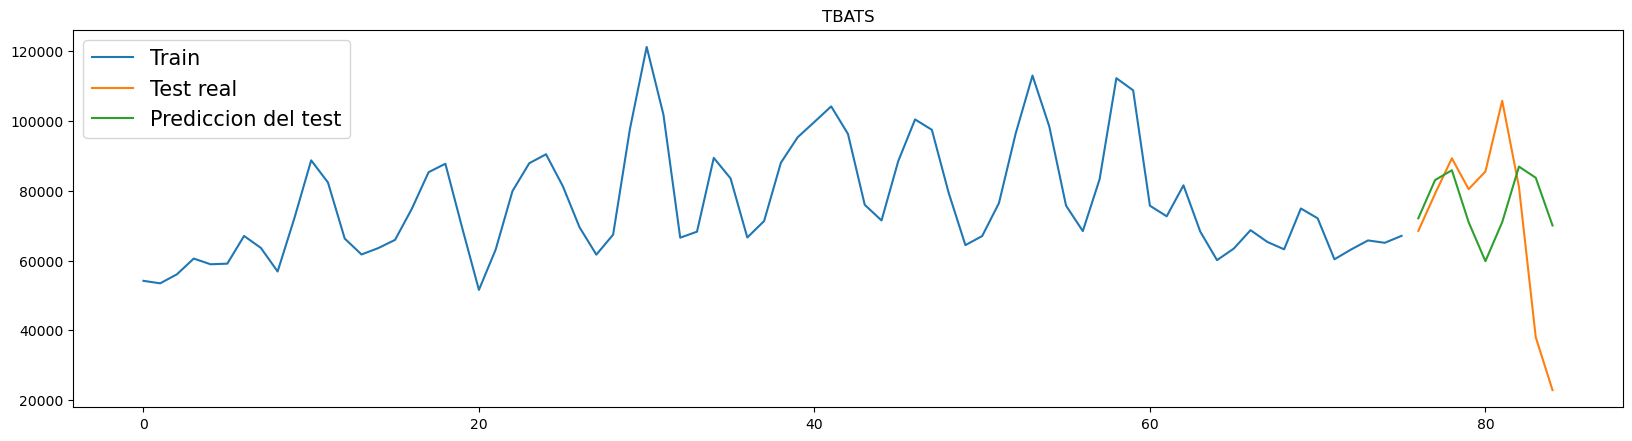

In [33]:
# Preparación del plot de los valores reales.
plot_test = np.full([len(df_no_index_mensual)], np.nan)
plot_test[len(train):len(df_no_index_mensual)] = test['cantidad']
# Preparación del plot de la predicción.
plot_forecast_mensual_post_covid = np.full([len(df_no_index_mensual)], np.nan)
plot_forecast_mensual_post_covid[len(train):len(df_no_index_mensual)] = forecast

plt.figure(figsize = (20, 5), dpi = 100)
plt.plot(train, label = 'Train')
plt.plot(plot_test, label = 'Test real')
plt.plot(plot_forecast_mensual_post_covid, label = 'Prediccion del test')
plt.title('TBATS')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

Es notable como en este caso hay menos datos que en el estudio semanal y por tanto los datos pueden llegar a ser menos representativos. De hecho como se apreciará a continuación, el modelo es explicativo de la forma, pero tampoco mejora en lo que respecta a los errores. Si bien mejora la claridad de la agrupación de los errores respecto del modelo anterior, el histograma en este caso no es muy esclarecedor.

El diagrama Q-Q por otro lado, sí que muestra una tendencia más regular, aunque tiene un claro bias en los últimos tramos del cuartil, por lo que hay un mayor bias en lo positivo.

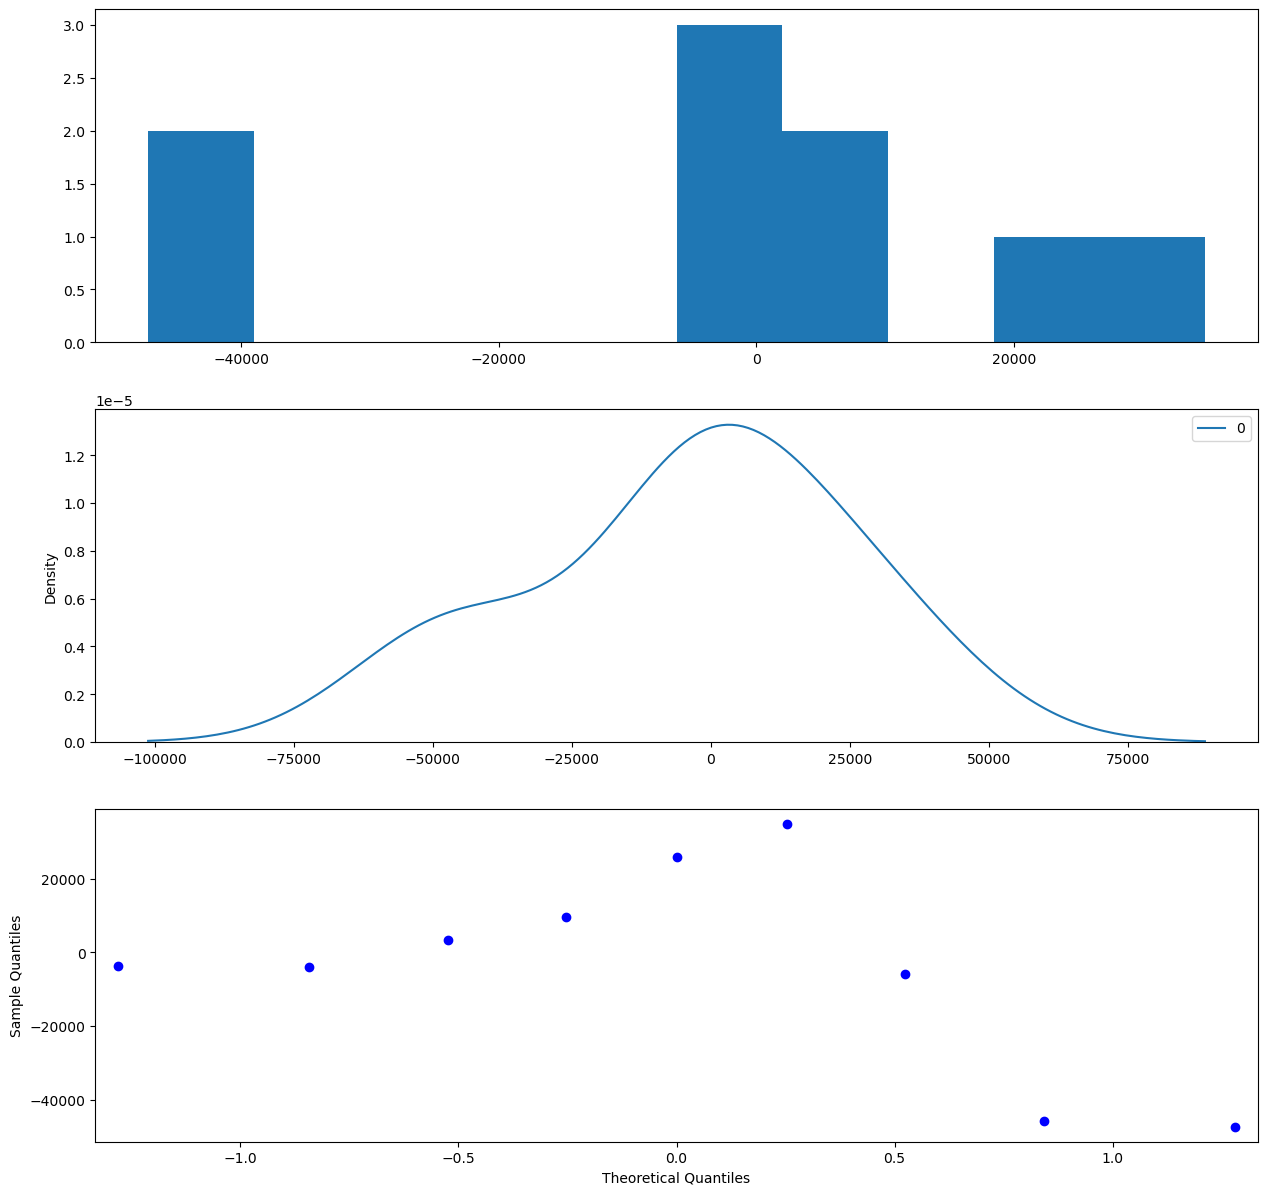

In [34]:
fig, ax = plt.subplots(3, figsize = (15, 15), dpi = 100)
residuos = pd.DataFrame([test['cantidad'].values[i] - forecast[i] for i in range(len(forecast))])
ax[0].hist(residuos)
sns.kdeplot(data = residuos, ax = ax[1])
sm.qqplot(residuos, ax = ax[2])
plt.show()

# =============================================================

### Predicción mensual del modelo si el covid no hubiera ocurrido

In [35]:
df_mensual_precovid = df[df.index < pd.to_datetime('2020-01-01', format = '%Y-%m-%d')] # Omitiendo el periodo covid.
# TBATS necesita un index sin timestamp
df_no_index_mensual_precovid = df_mensual_precovid.reset_index(drop = True)
train_c, test_c = divide(df_no_index_mensual_precovid, 0.9)
print(len(train_c))
print(len(test_c))

training_start = time.perf_counter() # inicia entrenamiento

estimator = TBATS(seasonal_periods = (1, 12)) # El periodo exacto original
model = estimator.fit(train_c['cantidad'])

training_end = time.perf_counter() # finaliza entrenamiento
train_time = training_end - training_start
print("Time consumed in training: %.3f" % train_time, "seconds")

forecast_c = model.forecast(steps = len(test_c))

54
6


D:\Python\lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: All seasonal periods should be values greater than 1. Ignoring all seasonal period values that do not meet this condition.
  warnings.warn(message, warning_type)


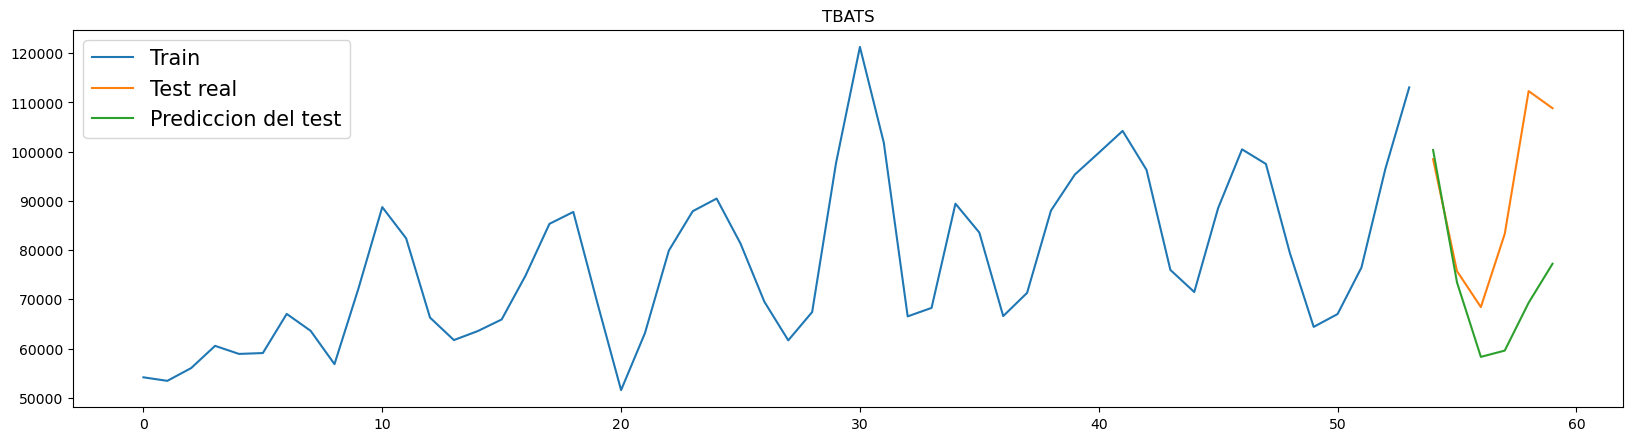

In [36]:
# Preparación del plot de los valores reales.
plot_test = np.full([len(df_no_index_mensual_precovid)], np.nan)
plot_test[len(train_c):len(df_no_index_mensual_precovid)] = test_c['cantidad']
# Preparación del plot de la predicción.
plot_forecast_mensual_pre_covid = np.full([len(df_no_index_mensual_precovid)], np.nan)
plot_forecast_mensual_pre_covid[len(train_c):len(df_no_index_mensual_precovid)] = forecast_c

plt.figure(figsize = (20, 5), dpi = 100)
plt.plot(train_c, label = 'Train')
plt.plot(plot_test, label = 'Test real')
plt.plot(plot_forecast_mensual_pre_covid, label = 'Prediccion del test')
plt.title('TBATS')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

Cuando se elimina el pico irregular, es evidente en tal caso como se aprecia una desviación de los errores hacia el positivo, y es que la predicción mostrada en este caso esta desviada completamente. Es capaz de predecir casi perfectamente el primer mes, pero tras eso sufre un bias positivo notable.

Al igual que en el caso anterior, el diagrama Q-Q reflejaría dicho bias positivo, lo cual de hecho se aprecia en la representación de la predicción vista anteriormente.

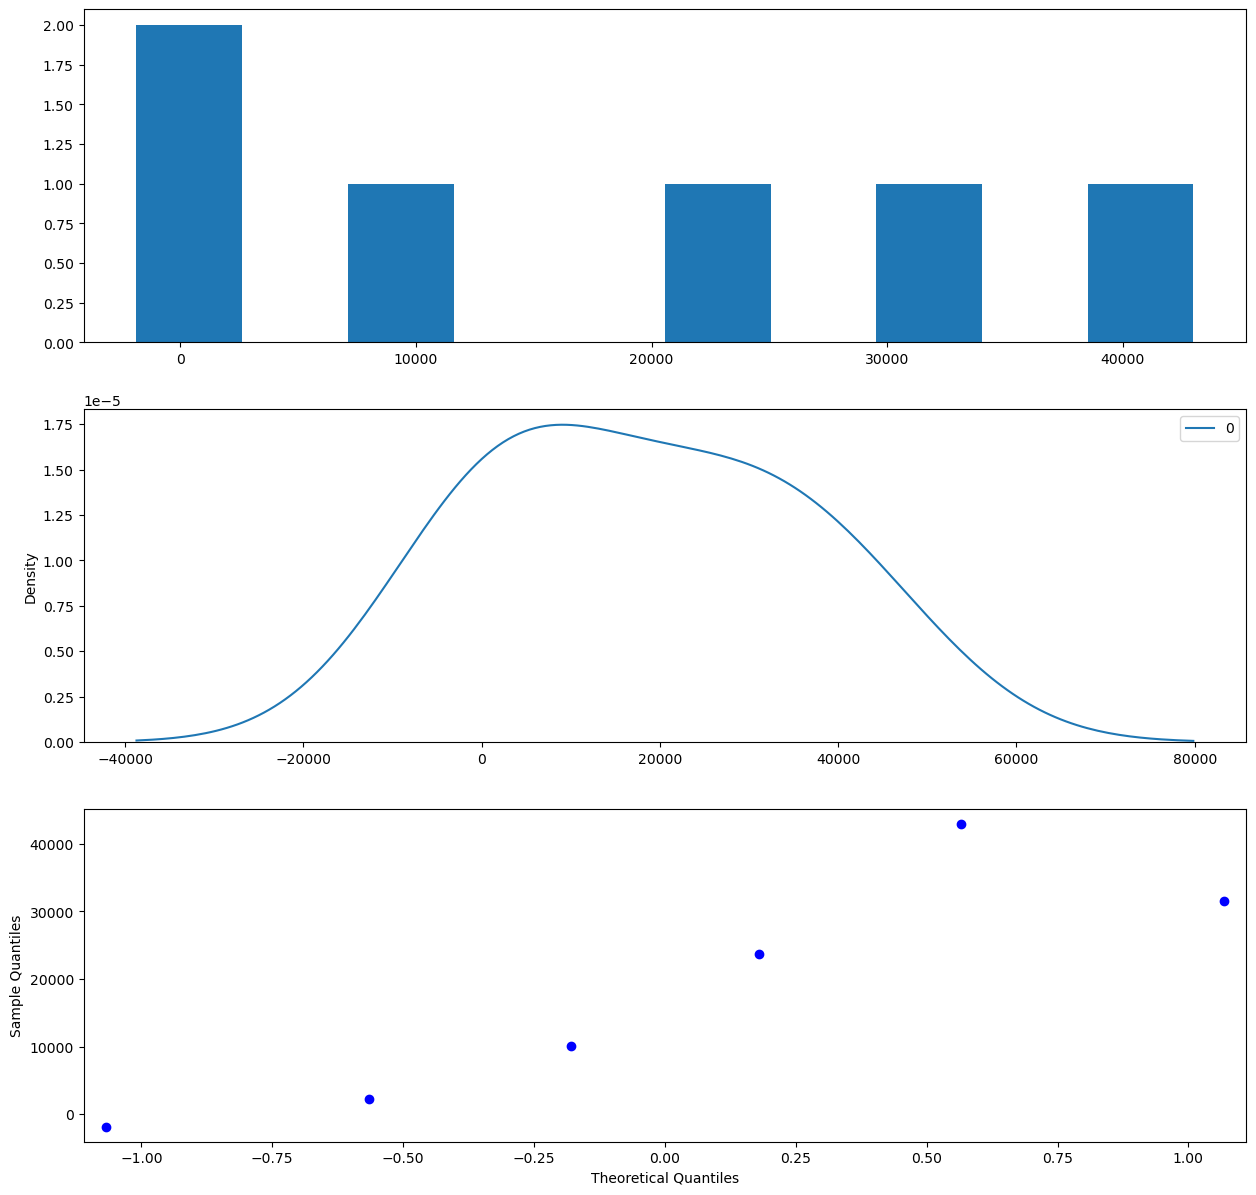

In [37]:
fig, ax = plt.subplots(3, figsize = (15, 15), dpi = 100)
residuos = pd.DataFrame([test_c['cantidad'].values[i] - forecast_c[i] for i in range(len(forecast_c))])
ax[0].hist(residuos)
sns.kdeplot(data = residuos, ax = ax[1])
sm.qqplot(residuos, ax = ax[2])
plt.show()

Mientras que la predicción mensual ha empeorado claramente con la parte covid, la comparación entre lo semanal y mensual con los **datos precovid** más regulares y constantes revelan que el comportamiento semanal es más predecible que el mensual. Siendo para los semanales la autocorrelación cone l primer lag del 69,4% con una correlación del 51% y para los mensuales un accuracy del 56,4%,
con una correlación del 45,4%.

In [38]:
forecast_accuracy(forecast, test['cantidad'])

<ipython-input-2-59b49a6db948>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:, None], actual[:,None]]), axis = 1)
<ipython-input-2-59b49a6db948>:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:, None], actual[:,None]]), axis = 1)
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release

{'mape': 0.4701712004414168,
 'me': 3655.337609557637,
 'mae': 19978.996223492748,
 'mpe': 0.29552408603568375,
 'rmse': 26586.03397779337,
 'acf1': 0.5526836932916385,
 'corr': -0.03422798749003678,
 'minmax': 0.24119410657294016}

In [39]:
forecast_accuracy(forecast_c, test_c['cantidad'])

<ipython-input-2-59b49a6db948>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:, None], actual[:,None]]), axis = 1)
<ipython-input-2-59b49a6db948>:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:, None], actual[:,None]]), axis = 1)


{'mape': 0.19239484550288885,
 'me': -18137.084290170333,
 'mae': 18757.423054382725,
 'mpe': -0.1860955511035348,
 'rmse': 24217.82091697024,
 'acf1': 0.5645335899465102,
 'corr': 0.4543856611768556,
 'minmax': 0.19233642780875482}

# =============================================================

### Comparación final

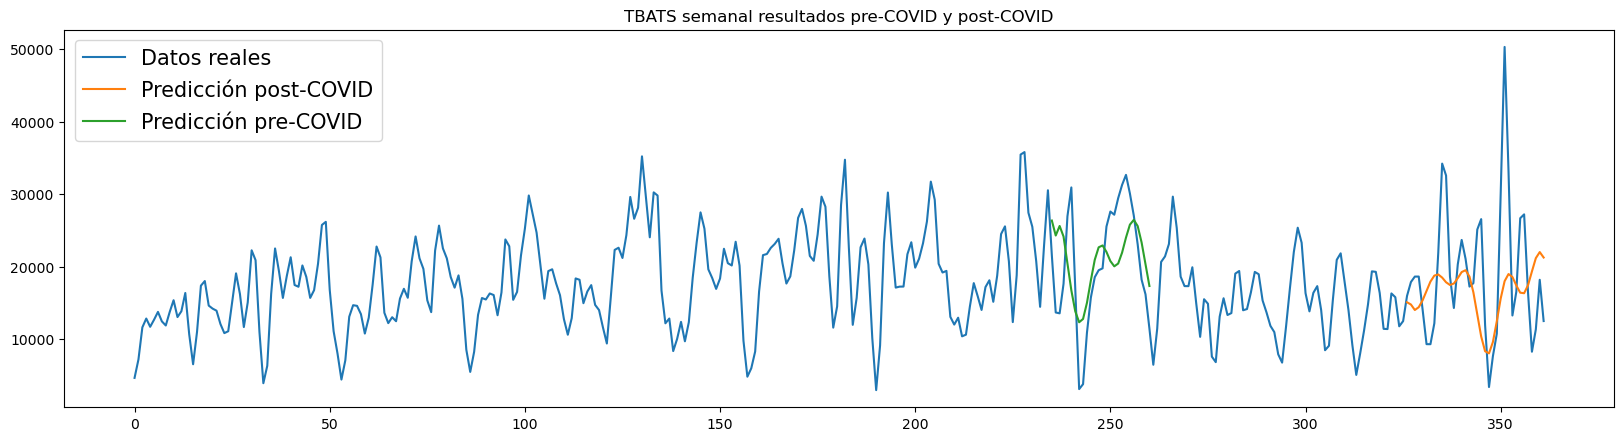

In [40]:
# Representación.
plt.figure(figsize = (20, 5), dpi = 100)
plt.plot(df_no_index.values, label = 'Datos reales')
plt.plot(plot_forecast_post_covid, label = 'Predicción post-COVID')
plt.plot(plot_forecast_pre_covid, label = 'Predicción pre-COVID')
plt.title('TBATS semanal resultados pre-COVID y post-COVID')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

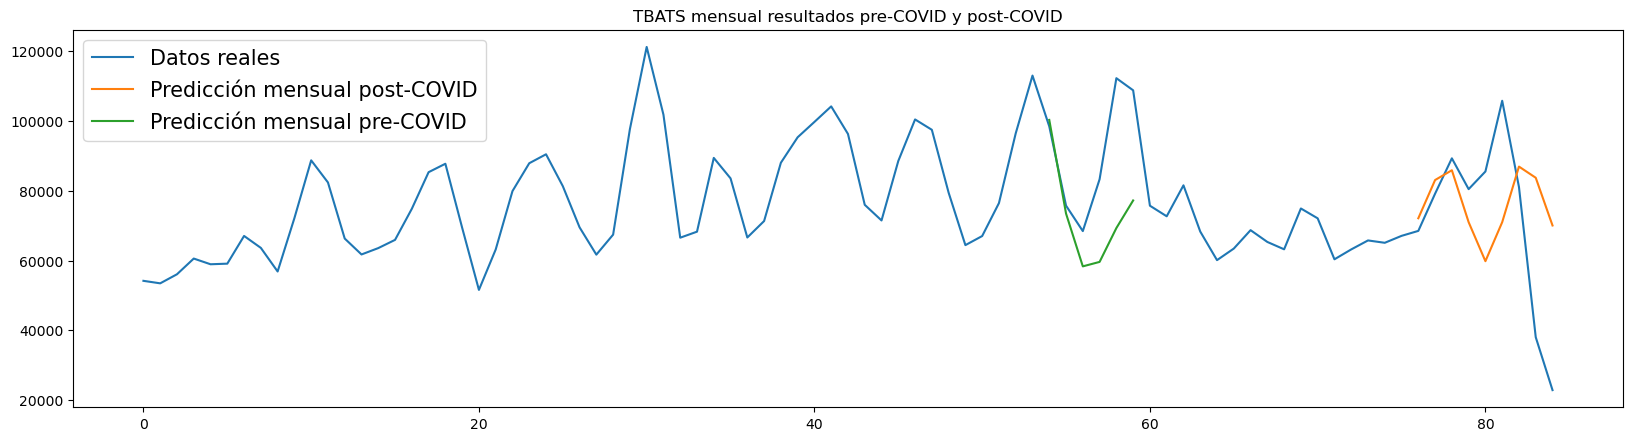

In [41]:
plt.figure(figsize = (20, 5), dpi = 100)
plt.plot(df_no_index_mensual.values, label = 'Datos reales')
plt.plot(plot_forecast_mensual_post_covid, label = 'Predicción mensual post-COVID')
plt.plot(plot_forecast_mensual_pre_covid, label = 'Predicción mensual pre-COVID')
plt.title('TBATS mensual resultados pre-COVID y post-COVID')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()